In [1]:
#play around with insightface model.
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from lfw import gen_all_pic_labels
from sklearn.cluster import DBSCAN
from insightface.data import get_image as ins_get_image
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
import umap
from mpl_toolkits.mplot3d import Axes3D


## Load in of the pics-files pairs
## In this notebook, I'm trying to clustering gender info.

In [2]:
pics,names,genders = gen_all_pic_labels('./lfw_funneled/')
#prepare gender
df = pd.DataFrame({'files':pics,'name':names,'gender':genders})

In [3]:
len(genders)

13233

In [4]:
#namely we have 5749 different faces
print(df.head)

<bound method NDFrame.head of                                                    files            name  \
0      ./lfw_funneled/Dennis_Powell/Dennis_Powell_000...   Dennis_Powell   
1      ./lfw_funneled/Dennis_Powell/Dennis_Powell_000...   Dennis_Powell   
2      ./lfw_funneled/Jaymon_Crabb/Jaymon_Crabb_0001.jpg    Jaymon_Crabb   
3      ./lfw_funneled/Henning_Scherf/Henning_Scherf_0...  Henning_Scherf   
4      ./lfw_funneled/Kellie_Coffey/Kellie_Coffey_000...   Kellie_Coffey   
...                                                  ...             ...   
13228  ./lfw_funneled/Hatsui_Hasuike/Hatsui_Hasuike_0...  Hatsui_Hasuike   
13229  ./lfw_funneled/John_Marburger/John_Marburger_0...  John_Marburger   
13230        ./lfw_funneled/Mark_Leno/Mark_Leno_0001.jpg       Mark_Leno   
13231    ./lfw_funneled/Troy_Hudson/Troy_Hudson_0001.jpg     Troy_Hudson   
13232  ./lfw_funneled/Camille_Colvin/Camille_Colvin_0...  Camille_Colvin   

       gender  
0        male  
1        male  
2        

In [6]:
df.gender.value_counts()

male      10271
female     2962
Name: gender, dtype: int64

## We can see that, the number of males are much higher than females, so far we don't do filter, but to see if the clustering algroithm could
## find the inner density un-match

In [16]:
df.iloc[1]['files']


'./lfw_funneled/Dennis_Powell/Dennis_Powell_0001.jpg'

In [8]:
males = df[df.gender=='male']

In [5]:
females = df[df.gender=='female']

In [13]:
num = len(df)

In [9]:
df = df.reset_index()

In [10]:
df

,index,files,name,gender
0,0,./lfw_funneled/Dennis_Powell/Dennis_Powell_000...,Dennis_Powell,male
1,1,./lfw_funneled/Dennis_Powell/Dennis_Powell_000...,Dennis_Powell,male
2,2,./lfw_funneled/Jaymon_Crabb/Jaymon_Crabb_0001.jpg,Jaymon_Crabb,male
3,3,./lfw_funneled/Henning_Scherf/Henning_Scherf_0...,Henning_Scherf,male
4,4,./lfw_funneled/Kellie_Coffey/Kellie_Coffey_000...,Kellie_Coffey,female
...,...,...,...,...
13228,13228,./lfw_funneled/Hatsui_Hasuike/Hatsui_Hasuike_0...,Hatsui_Hasuike,female
13229,13229,./lfw_funneled/John_Marburger/John_Marburger_0...,John_Marburger,male
13230,13230,./lfw_funneled/Mark_Leno/Mark_Leno_0001.jpg,Mark_Leno,male
13231,13231,./lfw_funneled/Troy_Hudson/Troy_Hudson_0001.jpg,Troy_Hudson,male


In [7]:
#prepare for the face recognizing
app = FaceAnalysis(name='my')
label = []
gender_label = []
app.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/r100.onnx recognition ['None', 3, 112, 112] 0.0 1.0
set det-size: (640, 640)


In [8]:
img = cv2.imread('./lfw_funneled/Yoriko_Kawaguchi/Yoriko_Kawaguchi_0003.jpg')
app.get(img)[0]['gender']

0

In [28]:
male_total = 0
female_total = 0
male_correct = 0
female_correct = 0

In [34]:
# pca = PCA(n_components=50)
# newX = pca.fit_transform(X) 
for i in range(num):
    pic = df.loc[i]['files']
    name = df.loc[i]['name']
    gender = df.loc[i]['gender']
    label.append(name)
    gender_label.append(gender)
    print(pic,name,gender)
    img = cv2.imread(pic)
    try:
        faces = app.get(img)
        if(not len(faces) == 1):
            continue
        det_gender = faces[0]['gender']
        if(gender=='male'):
            male_total+=1
            if(det_gender==1):
                male_correct+=1
        if(gender=='female'):
            female_total+=1
            if(det_gender==0):
                female_correct+=1
   
    except:
        pass

./lfw_funneled/Dennis_Powell/Dennis_Powell_0002.jpg Dennis_Powell male
./lfw_funneled/Dennis_Powell/Dennis_Powell_0001.jpg Dennis_Powell male
./lfw_funneled/Jaymon_Crabb/Jaymon_Crabb_0001.jpg Jaymon_Crabb male
./lfw_funneled/Henning_Scherf/Henning_Scherf_0001.jpg Henning_Scherf male
./lfw_funneled/Kellie_Coffey/Kellie_Coffey_0001.jpg Kellie_Coffey female
./lfw_funneled/Win_Aung/Win_Aung_0003.jpg Win_Aung male
./lfw_funneled/Win_Aung/Win_Aung_0001.jpg Win_Aung male
./lfw_funneled/Win_Aung/Win_Aung_0002.jpg Win_Aung male
./lfw_funneled/Win_Aung/Win_Aung_0004.jpg Win_Aung male
./lfw_funneled/Dean_Barker/Dean_Barker_0001.jpg Dean_Barker male
./lfw_funneled/Mel_Karmazin/Mel_Karmazin_0001.jpg Mel_Karmazin male
./lfw_funneled/Celso_Lafer/Celso_Lafer_0001.jpg Celso_Lafer male
./lfw_funneled/Nelson_Mandela/Nelson_Mandela_0002.jpg Nelson_Mandela male
./lfw_funneled/Nelson_Mandela/Nelson_Mandela_0004.jpg Nelson_Mandela male
./lfw_funneled/Nelson_Mandela/Nelson_Mandela_0001.jpg Nelson_Mandela male

In [15]:
print('Male accuracy:', male_correct/male_total)
print('female accuracy:', female_correct/female_total)

NameError: name 'male_correct' is not defined

In [9]:
#prepare for the face recognizing
app = FaceAnalysis(name='my')
label = []
gender_label = []
app.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/mafffia/.insightface/models/my/r100.onnx recognition ['None', 3, 112, 112] 0.0 1.0
set det-size: (640, 640)


In [13]:
females = females.reset_index()

In [14]:
# pca = PCA(n_components=50)
# newX = pca.fit_transform(X) 
female_total = 0
female_correct = 0
for i in range(len(females)):
    pic = females.loc[i]['files']
    name = females.loc[i]['name']
    gender = females.loc[i]['gender']
    label.append(name)
    gender_label.append(gender)
    print(pic,name,gender)
    img = cv2.imread(pic)
        
    faces = app.get(img)
    if(not len(faces) == 1):
        continue
    det_gender = faces[0]['gender']
    if(gender=='male'):
        male_total+=1
        if(det_gender==1):
            male_correct+=1
    if(gender=='female'):
        female_total+=1
        if(det_gender==0):
            female_correct+=1
   
    

./lfw_funneled/Kellie_Coffey/Kellie_Coffey_0001.jpg Kellie_Coffey female
./lfw_funneled/Mia_Mottley/Mia_Mottley_0001.jpg Mia_Mottley female
./lfw_funneled/Cathryn_Crawford/Cathryn_Crawford_0001.jpg Cathryn_Crawford female
./lfw_funneled/Cathy_Cunningham/Cathy_Cunningham_0001.jpg Cathy_Cunningham female
./lfw_funneled/Brenda_Wilson/Brenda_Wilson_0001.jpg Brenda_Wilson female
./lfw_funneled/Diana_Taylor/Diana_Taylor_0001.jpg Diana_Taylor female
./lfw_funneled/Linda_Mason/Linda_Mason_0001.jpg Linda_Mason female
./lfw_funneled/Sarah_Weddington/Sarah_Weddington_0001.jpg Sarah_Weddington female
./lfw_funneled/Aline_Chretien/Aline_Chretien_0001.jpg Aline_Chretien female
./lfw_funneled/Johnny_Htu/Johnny_Htu_0001.jpg Johnny_Htu female
./lfw_funneled/Angie_Arzola/Angie_Arzola_0001.jpg Angie_Arzola female
./lfw_funneled/Daniele_Hypolito/Daniele_Hypolito_0001.jpg Daniele_Hypolito female
./lfw_funneled/Claudine_Farrell/Claudine_Farrell_0001.jpg Claudine_Farrell female
./lfw_funneled/Heidi_Klum/Heid

In [18]:
female_correct


NameError: name 'female_correct' is not defined

## Cluster with T-sne

In [55]:

face_umap = TSNE(n_components=2).fit_transform(embs)
scan = DBSCAN(min_samples=2,eps=25).fit(face_umap)
# scan = KMeans(n_clusters=2, random_state=0).fit(face_umap)
clustering = list(scan.labels_)

out_name = []
out_clu = []
out_gender = []
for i in range(len(clustering)):
    if(clustering[i]>=0):
        out_name.append(label[i])
        out_clu.append(clustering[i])
        out_gender.append(gender_label[i])
df_out = pd.DataFrame({'real':out_name,'cluster':out_clu,'gender':out_gender})
pd.set_option('display.max_columns',1000)
df_out = df_out.sort_values(by='cluster')
# print(df_out.sort_values(by='real'))
for i in df_out.index:
    print(df_out.loc[i]['cluster'] , '  ' , df_out.loc[i]['real'],'  ' , df_out.loc[i]['gender'] )
print('total clustered points :%d'%len(out_name))

/Users/mafffia/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mafffia/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0    Gloria_Macapagal_Arroyo    female
0    Todd_Robbins    male
0    Monica_Seles    female
0    Cristiano_da_Matta    male
0    Doug_Moe    male
0    Elijah_Wood    male
0    Taylyn_Solomon    male
0    Jose_Serra    male
0    Michael_Schumacher    male
0    Naji_Sabri    male
0    George_W_Bush    male
0    Johan_Bruyneel    male
0    Carla_Sullivan    female
0    Michael_Kostelnik    male
0    Len_Jenoff    male
0    Carolyn_Dawn_Johnson    female
0    Mahathir_Mohamad    male
0    Scott_Sullivan    male
0    Edmund_Stoiber    male
0    Gerhard_Schroeder    male
0    Jessica_Lange    female
0    Bernice_Wong    female
0    Jeb_Bush    male
0    Luiz_Felipe_Scolari    male
0    Ariel_Sharon    male
0    Carlos_Menem    male
0    Aaron_Pena    male
0    John_Lithgow    male
0    Mike_Smith    male
0    Mark_Leno    male
0    Nia_Vardalos    female
0    Rob_Lowe    male
0    Carlos_Moya    male
0    Nancy_Pelosi    female
0    Fernando_Henrique_Cardoso    male
0    Junichiro_Koizumi  

/Users/mafffia/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/mafffia/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


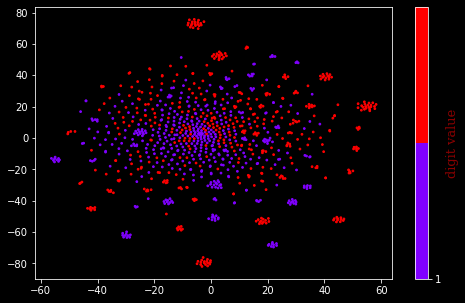

In [25]:
#pca = PCA(n_components=200, svd_solver='full')
#face_umap = pca.fit_transform(embs)
face_umap = TSNE(n_components=2).fit_transform(embs)
font = {'color':'darkred',"size":13,"family":"serif"}
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
color = []
for item in gender_label:
    if(item=='male'):
        color.append(1)
    else:
        color.append(2)
plt.scatter(face_umap[:,0],face_umap[:,1],c=color,alpha=1,s=3,cmap=plt.cm.get_cmap('rainbow',2))
cbar = plt.colorbar(ticks=range(2))
cbar.set_label(label="digit value",fontdict=font)
# plt.clim(-0.5,9.5)


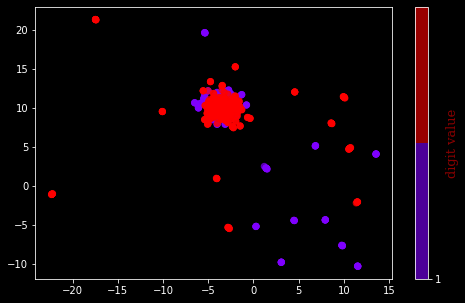

In [17]:
pca = PCA(n_components=30, svd_solver='full')
face_umap = pca.fit_transform(embs)
reducer = umap.UMAP(random_state=42,n_components=2)

face_umap = reducer.fit_transform(face_umap)
font = {'color':'darkred',"size":13,"family":"serif"}
plt.style.use("dark_background")
plt.figure(figsize=(8,5))
color = []
for item in gender_label:
    if(item=='male'):
        color.append(1)
    else:
        color.append(2)
plt.scatter(face_umap[:,0],face_umap[:,1],c=color,alpha=0.6,cmap=plt.cm.get_cmap('rainbow',2))
cbar = plt.colorbar(ticks=range(2))
cbar.set_label(label="digit value",fontdict=font)
# plt.clim(-0.5,9.5)


## Clustering with OPTICS

In [142]:
reducer = umap.UMAP(random_state=42,n_components=30)
face_umap = reducer.fit_transform(embs)
scan = OPTICS(min_samples=2,metric='cosine').fit(face_umap)
clustering = list(scan.labels_)

out_name = []
out_clu = []

for i in range(len(clustering)):
    if(clustering[i]>=0):
        out_name.append(label[i])
        out_clu.append(clustering[i])

df_out = pd.DataFrame({'real':out_name,'cluster':out_clu})
pd.set_option('display.max_columns',1000)
df_out = df_out.sort_values(by='cluster')
# print(df_out.sort_values(by='real'))
for i in df_out.index:
    print(df_out.loc[i]['cluster'] , '  ' , df_out.loc[i]['real'])
print('total clustered points :%d'%len(out_name))

0    Brock_Berlin
0    Terence_Newman
1    Vin_Diesel
1    Vin_Diesel
1    Clay_Campbell
2    Raul_Gonzalez
2    Stephane_Rousseau
3    Bill_Byrne
3    Alex_Popov
4    Peter_Hartz
4    Giovanny_Cordoba
4    Taylor_Twellman
5    Wolfgang_Schwarz
5    Saoud_Al_Faisal
6    David_Howard
6    Hermogenes_Ebdane_Jr
6    Billy_Bob_Thornton
6    Brett_Perry
6    Hutomo_Mandala_Putra
7    Nicolas_Massu
7    Kaisser_Bazan
8    Alberto_Acosta
8    Eric_Schacht
8    Glenn_Rivers
9    Mike_Bair
9    Peter_Mullan
10    Tayshaun_Prince
10    David_Zeplowitz
10    Crispin_Glover
10    Chris_Cornell
11    Nawabzada_Nasrullah_Khan
11    Matt_Morris
11    Soenarno
12    Dick_Smothers
12    Kim_Dong-hwa
13    Paul_Tracy
13    Leuris_Pupo
13    Ed_Case
13    Max_Baucus
14    Isaiah_Washington
14    Isaiah_Washington
14    Hussein_Malik
15    Walt_Harris
15    Woodrow_Stanley
15    Bobby_Bowden
15    Mike_Richter
16    Michael_Goldrich
16    Yuvraj_Singh
16    Bill_Butler
17    Danny_Glover
17    Darren_Clar

In [65]:
face_umap[:,1].reshape(1,-1).shape

(1, 1000)

In [73]:
scan.labels_.shape

(1000,)